# GoEmo Week 3

- optimize multi class models with hyperparameter optimizations
- use data with ambiguous observations (just positive/neutral/negative)
- measure with precision and recall
- predict optimized models on reddit comments

In [40]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
GoEmo_df = pd.read_csv('GoEmotions_Sentiment_simple.csv')
GoEmo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56873 entries, 0 to 56872
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       56873 non-null  object
 1   Sentiment  56873 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 888.8+ KB


In [42]:
GoEmo_df

,text,Sentiment
0,Fast as [NAME] will carry me. Seriously uptown...,0
1,You blew it. They played you like a fiddle.,1
2,TL;DR No more Superbowls for [NAME]. Get ready...,2
3,So much time saved. Not.,3
4,Emotes have a ridiculous amount of effort put ...,1
...,...,...
56868,[NAME]. I’m not sure you’ll feel the same way ...,3
56869,I can see why! I would totally be offended too!,2
56870,Approaching doesn't work unless you are [NAME]...,1
56871,Hahaha perfect.,0


positive = 0
neutral = 1
negative = 2

In [43]:
no_amb = GoEmo_df[GoEmo_df['Sentiment'] < 3]

In [44]:
no_amb

,text,Sentiment
0,Fast as [NAME] will carry me. Seriously uptown...,0
1,You blew it. They played you like a fiddle.,1
2,TL;DR No more Superbowls for [NAME]. Get ready...,2
4,Emotes have a ridiculous amount of effort put ...,1
5,Just life.. I feel like i'm just a parasite th...,2
...,...,...
56867,"Stop, this is a safe space.",1
56869,I can see why! I would totally be offended too!,2
56870,Approaching doesn't work unless you are [NAME]...,1
56871,Hahaha perfect.,0


In [45]:
# store simplified data in X and y
X = no_amb['text']
y = no_amb['Sentiment']

In [46]:
# splitting our data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

# 1. Instantiate
bagofwords = CountVectorizer(stop_words="english",
                             min_df= 20)
# 2. Fit
bagofwords.fit(X_train)

# 3. Transform
X_train_transformed = bagofwords.transform(X_train)
X_test_transformed = bagofwords.transform(X_test) 
X_train_transformed

<38762x1713 sparse matrix of type '<class 'numpy.int64'>'
	with 154603 stored elements in Compressed Sparse Row format>

In [48]:
from sklearn.linear_model import LogisticRegression

# Fitting a model
logreg = LogisticRegression(C = 0.1)
logreg.fit(X_train_transformed, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train_transformed, y_train)}")
print(f"Test score: {logreg.score(X_test_transformed, y_test)}")

Train score: 0.7021825499200247
Test score: 0.6811392307096974


In [49]:
# predict on test data to compare with y_test
y_pred = logreg.predict(X_test_transformed)

In [50]:
# make confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

In [51]:
display(cf_matrix)

array([[3702, 1323,  153],
       [ 606, 3912,  395],
       [ 258, 1385, 1187]], dtype=int64)

In [52]:
# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Pos", "Predicted Neut", 'Predicted Neg'],
    index=["True Pos", "True Neut", 'True Neg']
)

display(cf_df)

,Predicted Pos,Predicted Neut,Predicted Neg
True Pos,3702,1323,153
True Neut,606,3912,395
True Neg,258,1385,1187


In [53]:
# check prescision/recall scores
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.81      0.71      0.76      5178
           1       0.59      0.80      0.68      4913
           2       0.68      0.42      0.52      2830

    accuracy                           0.68     12921
   macro avg       0.70      0.64      0.65     12921
weighted avg       0.70      0.68      0.68     12921



In [54]:
y.value_counts(normalize = True)

0    0.400712
1    0.380280
2    0.219008
Name: Sentiment, dtype: float64

# Hyperparameter optimization

## Logistic Regression
- solvers (lbfgs, sag, saga, liblinear), 
- penalty (l2 vs l1)
- C regularization strength (0.0001 - 100)

In [55]:
# 30% split, validation sets
X_train_new, X_validation, y_train_new, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state=1, stratify=y_train)

In [56]:
# check shapes of new sets
print(f'Shape of X validation set: {X_validation.shape}')
print(f'Shape of X train set: {X_train_new.shape}')

print(f'Shape of y validation set: {y_validation.shape}')
print(f'Shape of y train set: {y_train_new.shape}')

Shape of X validation set: (11629,)
Shape of X train set: (27133,)
Shape of y validation set: (11629,)
Shape of y train set: (27133,)


In [57]:
# check if stratify worked
y_train_new.value_counts(normalize = True)

0    0.400693
1    0.380312
2    0.218995
Name: Sentiment, dtype: float64

In [58]:
y_validation.value_counts(normalize = True)

0    0.400722
1    0.380256
2    0.219021
Name: Sentiment, dtype: float64

In [59]:
# 1. Instantiate
bagofwords_hyper = CountVectorizer(stop_words="english",
                             min_df= 20)
# 2. Fit
bagofwords_hyper.fit(X_train_new)

# 3. Transform
X_train_transformed_new = bagofwords_hyper.transform(X_train_new)
X_validation_transformed_new = bagofwords_hyper.transform(X_validation) 

In [60]:
# for loop to  to find optimal value of K
solver_list = ['lbfgs', 'sag', 'saga', 'liblinear']
train_scores = []
validation_scores = []


for sol in solver_list:  
    logreg_hyper = LogisticRegression(C=0.1, solver = sol)
    logreg_hyper.fit(X_train_transformed_new, y_train_new)
    
    # Evaluate
    train_scores.append(logreg_hyper.score(X_train_transformed_new, y_train_new))
    validation_scores.append(logreg_hyper.score(X_validation_transformed_new, y_validation))

In [61]:
train_scores

[0.6956473666752663,
 0.6956842221648915,
 0.6959422105922677,
 0.6880919913021044]

In [62]:
validation_scores

[0.6728007567288675,
 0.6728007567288675,
 0.6732307163126666,
 0.6709949264769112]

SAGA solver is the best?

In [63]:
# for loop to  to find optimal value of K
c_list = [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
train_scores = []
validation_scores = []


for C_ in c_list:  
    logreg_hyper = LogisticRegression(solver = 'saga', C=C_)
    logreg_hyper.fit(X_train_transformed_new, y_train_new)
    
    # Evaluate
    train_scores.append(logreg_hyper.score(X_train_transformed_new, y_train_new))
    validation_scores.append(logreg_hyper.score(X_validation_transformed_new, y_validation))

c:\Users\trann\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\trann\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\trann\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\trann\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [64]:
train_scores

[0.7106844064423395,
 0.7106844064423395,
 0.7107581174215899,
 0.7108686838904655,
 0.7096524527328345,
 0.6959790660818929,
 0.6402904212582464,
 0.5958427007702798,
 0.40091401614270444,
 0.4006928832049534]

In [65]:
validation_scores

[0.6674692578897584,
 0.6674692578897584,
 0.6672972740562387,
 0.6677272336400378,
 0.6680712013070771,
 0.6732307163126666,
 0.634362369937226,
 0.5905924843064752,
 0.4007223321007825,
 0.4007223321007825]

C = 0.01 is best

In [66]:
# for loop to  to find optimal value of K
pen_list = ['l1','l2','elasticnet','none']
train_scores = []
validation_scores = []


for pen in pen_list:  
    logreg_hyper = LogisticRegression(solver = 'saga', C=0.1, penalty = pen, l1_ratio=1)
    logreg_hyper.fit(X_train_transformed_new, y_train_new)
    
    # Evaluate
    train_scores.append(logreg_hyper.score(X_train_transformed_new, y_train_new))
    validation_scores.append(logreg_hyper.score(X_validation_transformed_new, y_validation))

c:\Users\trann\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\trann\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\trann\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
c:\Users\trann\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\trann\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [67]:
train_scores

[0.6702539343235175,
 0.6959422105922677,
 0.6702539343235175,
 0.7107212619319647]

In [68]:
validation_scores

[0.6642015650528851,
 0.6732307163126666,
 0.6642015650528851,
 0.6674692578897584]

L2 is the best penalty?

Summary
- solver = saga
- C = 0.1
- penalty = l2

In [69]:
# Fitting a model
logreg_hyper = LogisticRegression(solver = 'saga',
                             C = 0.1, 
                             penalty='l2')

logreg_hyper.fit(X_train_transformed, y_train)

# Training and test score
print(f"Train score: {logreg_hyper.score(X_train_transformed, y_train)}")
print(f"Test score: {logreg_hyper.score(X_test_transformed, y_test)}")

Train score: 0.702672720705846
Test score: 0.6813714108815108


65.08-65.06 = 0.02 increase in accuracy
hmmm?

In [70]:
# predict on test data to compare with y_test
y_pred = logreg_hyper.predict(X_test_transformed)


# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Pos", "Predicted Neut", 'Predicted Neg'],
    index=["True Pos", "True Neut", 'True Neg']
)

display(cf_df)

,Predicted Pos,Predicted Neut,Predicted Neg
True Pos,3702,1323,153
True Neut,606,3912,395
True Neg,258,1382,1190


In [71]:
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.81      0.71      0.76      5178
           1       0.59      0.80      0.68      4913
           2       0.68      0.42      0.52      2830

    accuracy                           0.68     12921
   macro avg       0.70      0.64      0.65     12921
weighted avg       0.70      0.68      0.68     12921



Overall my model got worse?

Use old model before trying to optimize


### Reddit comment predictions
- to see how a trained model looks on real world data
- use base models and save everything to a big csv for dashboard 

In [72]:
reddit = pd.read_csv('reddit_comments.csv')

In [73]:
reddit.rename(columns = {'0':'text'}, inplace = True)

In [74]:
reddit

,text
0,"Chill everyone, the Newspost says that 7.33 wi..."
1,At least CM (Crystal Maiden) not touched.
2,I wanna work with this devs since the work two...
3,7.32e hahahahahah
4,# 7.32e Summary\n\n* New hero added to the gam...
...,...
187,4.2 GB for minor Lina nerf. \n\n\nI'm done wi...
188,This is bad lol. Barely any changes other than...
189,"Hahahaha we overhyped the patch, it's literall..."
190,No 7.33


In [75]:
reddit_text = reddit['text']

In [76]:
reddit_text

0      Chill everyone, the Newspost says that 7.33 wi...
1              At least CM (Crystal Maiden) not touched.
2      I wanna work with this devs since the work two...
3                                      7.32e hahahahahah
4      # 7.32e Summary\n\n* New hero added to the gam...
                             ...                        
187    4.2 GB for minor Lina nerf.  \n\n\nI'm done wi...
188    This is bad lol. Barely any changes other than...
189    Hahahaha we overhyped the patch, it's literall...
190                                              No 7.33
191    This has to be what sunsfan was talking about ...
Name: text, Length: 192, dtype: object

In [77]:
reddit_transformed =  bagofwords.transform(reddit_text)

In [78]:
reddit_transformed

<192x1713 sparse matrix of type '<class 'numpy.int64'>'
	with 883 stored elements in Compressed Sparse Row format>

In [79]:
reddit_log_pred = logreg.predict(reddit_transformed)

In [80]:
reddit_log_pred

array([0, 1, 1, 1, 0, 1, 2, 2, 1, 0, 0, 2, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2,
       0, 1, 1, 1, 0, 0, 2, 0, 0, 1, 1, 0, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 0, 0, 1, 1, 2, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 0, 1, 0, 2, 2, 1, 0, 1, 1, 0,
       1, 1, 2, 2, 0, 1, 1, 2, 2, 0, 1, 1, 0, 2, 1, 2, 1, 1, 0, 1, 1, 2,
       1, 1, 2, 0, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1, 0, 2, 2,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 0, 2, 1, 2], dtype=int64)

In [81]:
reddit['Logistic_Regression'] = reddit_log_pred

In [82]:
reddit

,text,Logistic_Regression
0,"Chill everyone, the Newspost says that 7.33 wi...",0
1,At least CM (Crystal Maiden) not touched.,1
2,I wanna work with this devs since the work two...,1
3,7.32e hahahahahah,1
4,# 7.32e Summary\n\n* New hero added to the gam...,0
...,...,...
187,4.2 GB for minor Lina nerf. \n\n\nI'm done wi...,1
188,This is bad lol. Barely any changes other than...,0
189,"Hahahaha we overhyped the patch, it's literall...",2
190,No 7.33,1


<AxesSubplot:>

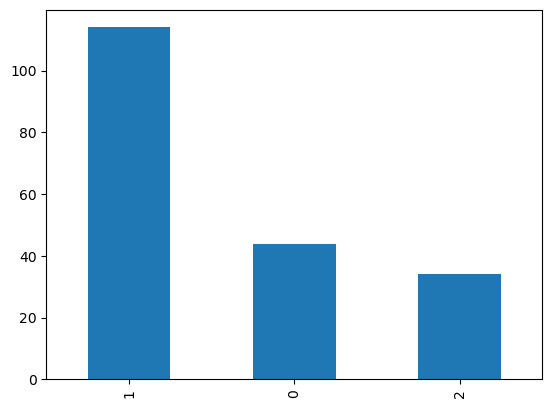

In [97]:
reddit['Logistic_Regression'].value_counts().plot(kind = 'bar')

In [84]:
from sklearn.svm import LinearSVC
SVM_model = LinearSVC(C=0.11)
SVM_model.fit(X_train_transformed, y_train)

print(f"The TRAIN classification accuracy is:  {SVM_model.score(X_train_transformed,y_train)}")
print(f"The TEST classification accuracy is:  {SVM_model.score(X_test_transformed,y_test)}")

The TRAIN classification accuracy is:  0.7110056240648057
The TEST classification accuracy is:  0.684234966333875


In [85]:
# predict on test data to compare with y_test
SVM_pred = SVM_model.predict(reddit_transformed)

In [86]:
reddit['SVM'] = SVM_pred

In [87]:
reddit

,text,Logistic_Regression,SVM
0,"Chill everyone, the Newspost says that 7.33 wi...",0,0
1,At least CM (Crystal Maiden) not touched.,1,1
2,I wanna work with this devs since the work two...,1,1
3,7.32e hahahahahah,1,1
4,# 7.32e Summary\n\n* New hero added to the gam...,0,0
...,...,...,...
187,4.2 GB for minor Lina nerf. \n\n\nI'm done wi...,1,1
188,This is bad lol. Barely any changes other than...,0,0
189,"Hahahaha we overhyped the patch, it's literall...",2,2
190,No 7.33,1,1


In [88]:
from sklearn.tree import DecisionTreeClassifier
#Fit to the training data
DT_model = DecisionTreeClassifier(max_depth=20)
DT_model.fit(X_train_transformed, y_train)

print(f"The TRAIN classification accuracy is:  {DT_model.score(X_train_transformed,y_train)}")
print(f"The TEST classification accuracy is:  {DT_model.score(X_test_transformed,y_test)}")

The TRAIN classification accuracy is:  0.6048449512409061
The TEST classification accuracy is:  0.5898924231870598


In [89]:
# predict on test data to compare with y_test
DT_pred = DT_model.predict(reddit_transformed)

In [90]:
reddit['Decision_Tree'] = DT_pred

In [91]:
reddit

,text,Logistic_Regression,SVM,Decision_Tree
0,"Chill everyone, the Newspost says that 7.33 wi...",0,0,1
1,At least CM (Crystal Maiden) not touched.,1,1,1
2,I wanna work with this devs since the work two...,1,1,1
3,7.32e hahahahahah,1,1,1
4,# 7.32e Summary\n\n* New hero added to the gam...,0,0,1
...,...,...,...,...
187,4.2 GB for minor Lina nerf. \n\n\nI'm done wi...,1,1,1
188,This is bad lol. Barely any changes other than...,0,0,0
189,"Hahahaha we overhyped the patch, it's literall...",2,2,2
190,No 7.33,1,1,1


In [92]:
from sklearn.neighbors import KNeighborsClassifier

# Instantiate the model & fit it to our data
KNN_model = KNeighborsClassifier(n_neighbors=5)
KNN_model.fit(X_train_transformed, y_train)

print(f"The TRAIN classification accuracy is:  {KNN_model.score(X_train_transformed,y_train)}")
print(f"The TEST classification accuracy is:  {KNN_model.score(X_test_transformed,y_test)}")

c:\Users\trann\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


The TRAIN classification accuracy is:  0.6934626696248903
The TEST classification accuracy is:  0.5968578283414596


c:\Users\trann\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [93]:
# predict on test data to compare with y_test
KNN_pred = KNN_model.predict(reddit_transformed)

c:\Users\trann\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [94]:
reddit['KNN'] = KNN_pred

In [95]:
reddit

,text,Logistic_Regression,SVM,Decision_Tree,KNN
0,"Chill everyone, the Newspost says that 7.33 wi...",0,0,1,1
1,At least CM (Crystal Maiden) not touched.,1,1,1,1
2,I wanna work with this devs since the work two...,1,1,1,0
3,7.32e hahahahahah,1,1,1,1
4,# 7.32e Summary\n\n* New hero added to the gam...,0,0,1,1
...,...,...,...,...,...
187,4.2 GB for minor Lina nerf. \n\n\nI'm done wi...,1,1,1,1
188,This is bad lol. Barely any changes other than...,0,0,0,0
189,"Hahahaha we overhyped the patch, it's literall...",2,2,2,2
190,No 7.33,1,1,1,1


In [96]:
reddit.to_csv('dota_comments.csv', index = False)